In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle
import urllib.request
import os

import matplotlib.pyplot as plt

In [2]:
def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno

def get_prio_shape():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO'#local
    path_prio = location + '/priogrid_shapefiles.zip'

    if os.path.isfile(path_prio) == True:
        
        print('File already downloaded')
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    else:
        print('Beginning file download PRIO...')
        url_prio = 'http://file.prio.no/ReplicationData/PRIO-GRID/priogrid_shapefiles.zip'

        urllib.request.urlretrieve(url_prio, path_prio)
        prio_grid = gpd.read_file('zip://' + path_prio)

        prio_grid =  pd.DataFrame(prio_grid.drop(columns = ['geometry']))

    return prio_grid


def get_gwno():

    #location = '/home/projects/ku_00017/data/raw/PRIO'
    location = '/home/simon/Documents/Bodies/data/PRIO' #local
    #path_gwno = location + '/PRIO-GRID Yearly Variables for 2003-2009 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API
    path_gwno = location + '/PRIO-GRID Yearly Variables for 1989-2014 - 2022-06-16.csv' #https://grid.prio.org/#/download # need to figrue out the API

    # why not just go 1989 - 2019 like ucdp...

    gwno = pd.read_csv(path_gwno)

    return gwno


def get_ucdp():

    #location = '/home/projects/ku_00017/data/raw/UCDP'
    location = '/home/simon/Documents/Bodies/data/UCDP' #local
    path_ucdp = location + "/ged201-csv.zip"
    
    if os.path.isfile(path_ucdp) == True:
        print('file already downloaded')
        ucdp = pd.read_csv(path_ucdp, low_memory=False)


    else: 
        print('Beginning file download UCDP...')

        url_ucdp = 'https://ucdp.uu.se/downloads/ged/ged201-csv.zip'
    
        urllib.request.urlretrieve(url_ucdp, path_ucdp)
        ucdp = pd.read_csv(path_ucdp, low_memory=False)

    return ucdp


In [3]:
def add_months(ucdp, world_grid):

    diff = ucdp['year'].max() - world_grid['year'].max()

    subset_list = []

    for i in np.arange(1, diff+1, 1):

        subset = world_grid[world_grid['year'] == world_grid['year'].max()].copy()
        subset['year'] = world_grid['year'].max() + i

        subset_list.append(subset)

    new_years = pd.concat(subset_list)
    world_grid_all_years = pd.concat([world_grid, new_years])

    month = [str(i).zfill(2) for i in np.arange(1,13,1)]
    world_grid_all_years.loc[:,'month'] = world_grid_all_years.apply(lambda _: month, axis=1)
    world_grid_all_months = world_grid_all_years.sort_values('year').explode('month').copy()
    world_grid_all_months['year_months_start'] =  world_grid_all_months['year'].astype(str) + '-' +  world_grid_all_months['month'].astype(str)

    year_months = sorted(world_grid_all_months['year_months_start'].unique())
    ts = len(year_months)
    month_ids = np.arange(109, ts + 109, 1)
    month_id_dict = dict(zip(year_months,month_ids))
    month_df = pd.DataFrame({'year_months_start' : year_months, 'month_id': month_ids})
    world_grid_all_months_id = world_grid_all_months.merge(month_df, how = 'left', on = 'year_months_start')

    return world_grid_all_months_id


def prio_ucdp_merge(ucdp, world_grid_all_months):
    ucdp_tmp1 = ucdp.copy()

    ucdp_tmp1['year_months_start'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD
    ucdp_tmp1['year_months_end'] = ucdp_tmp1['date_start'].str.slice(start = 0, stop = 7) # Date YYYY-MM-DD


    mask1 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_start'].str.slice(start = 0, stop = 4).astype(int))
    mask2 = (ucdp_tmp1['year'] != ucdp_tmp1['year_months_end'].str.slice(start = 0, stop = 4).astype(int))

    # correction. Note that end and start year for the four entries that is corrected is the same.
    ucdp_tmp1.loc[mask1 | mask2, 'year'] = ucdp_tmp1.loc[mask1 | mask2,'year_months_start'].str.slice(start = 0, stop = 4).astype(int)

    feature_list = ['deaths_a','deaths_b', 'deaths_civilians', 'deaths_unknown','best', 'high', 'low']

    ucdp_monthly_unit = ucdp_tmp1.groupby(['year_months_start','year', 'priogrid_gid']).sum()[feature_list].reset_index()
    ucdp_monthly_unit.rename(columns={'priogrid_gid':'gid'}, inplace=True)

    ucdp_monthly_unit['log_best'] = np.log(ucdp_monthly_unit['best'] +1)
    ucdp_monthly_unit['log_low'] = np.log(ucdp_monthly_unit['low'] +1)
    ucdp_monthly_unit['log_high'] = np.log(ucdp_monthly_unit['high'] +1)

    prio_ucdp_df = world_grid_all_months.merge(ucdp_monthly_unit, how = 'left', on = ['gid', 'year_months_start', 'year'])
    prio_ucdp_df.fillna(0, inplace=True)

    return prio_ucdp_df

In [4]:
# and you can also add some prio stuff here.

In [5]:
def make_volumn(df):

    # we start with wat we know - but there is no reason not to try with more down til line.

    sub_df = df[['gid', 'xcoord', 'ycoord', 'month_id', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    sub_df_sorted = sub_df.sort_values(['month_id', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = sub_df['xcoord'].unique().shape[0]
    y_dim = sub_df['ycoord'].unique().shape[0]
    z_dim = sub_df['month_id'].unique().shape[0]

    ucpd_vol = np.array(sub_df_sorted).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol

In [6]:
prio_grid = get_prio_shape()
gwno = get_gwno()
ucdp = get_ucdp()

File already downloaded


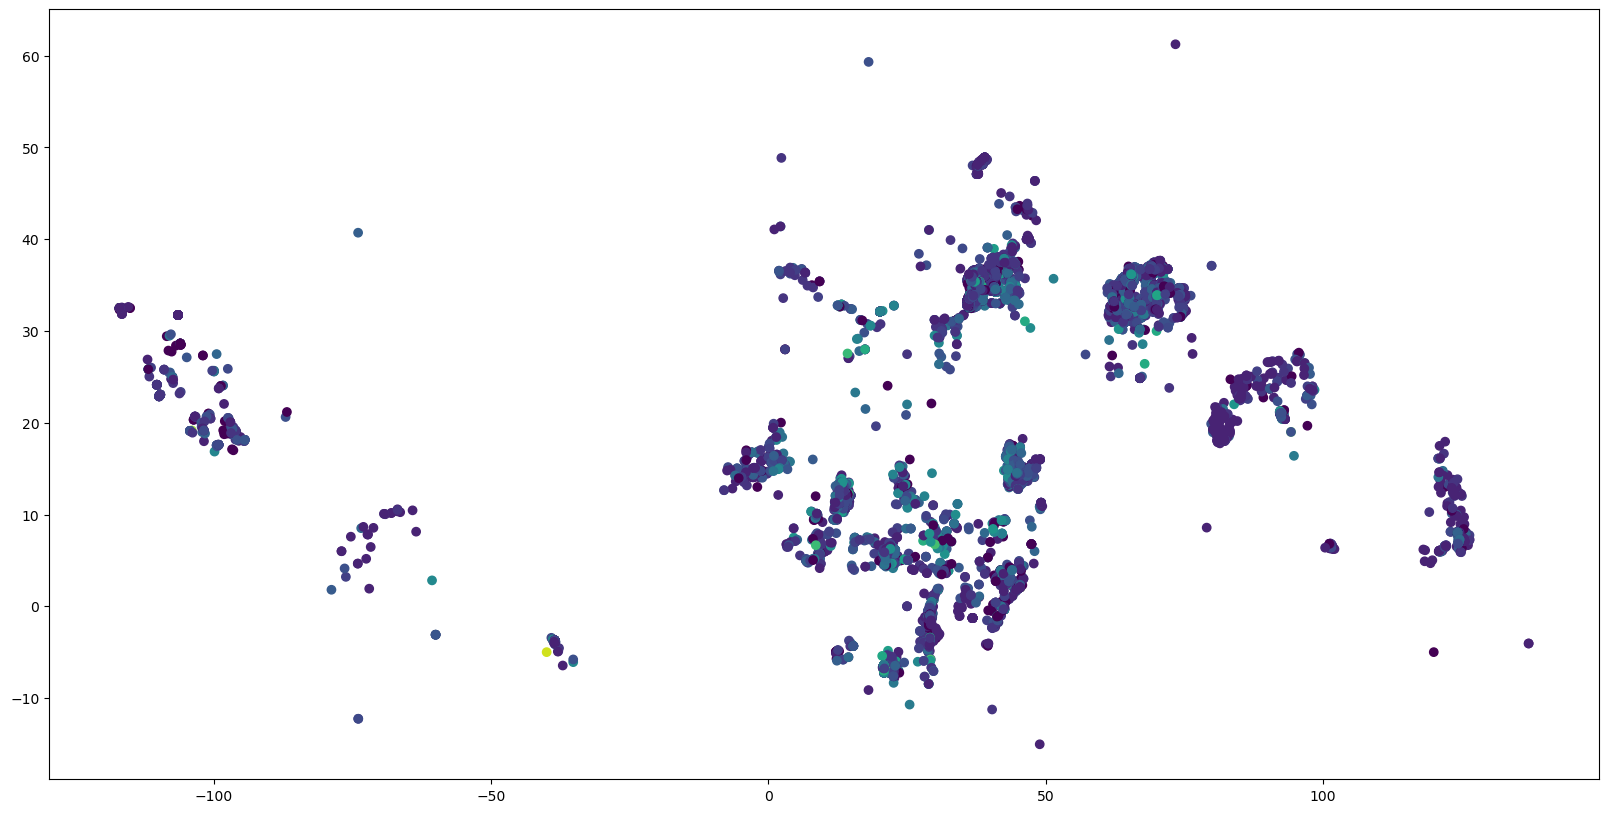

In [ ]:
# x = ucdp[ucdp['year'] == 2017]['longitude']
# y = ucdp[ucdp['year'] == 2017]['latitude']
# z = np.log(ucdp[ucdp['year'] == 2017]['best'] + 1)

# plt.figure(figsize= [20,10])
# plt.scatter(x, y, c = z, marker= 'o')
# plt.show()

In [ ]:
def monthly_grid(prio_grid, ucdp):

    years = [sorted(ucdp['year'].unique())] * prio_grid.shape[0]

    years = years[:5] # just the first five for now

    months = [list(np.arange(1, 13))] * prio_grid.shape[0]

    prio_grid['year'] = years
    prio_grid['month'] = months

    prio_grid = prio_grid.explode('year').reset_index(drop=True) 
    prio_grid = prio_grid.explode('month').reset_index(drop=True) 

    return prio_grid

In [ ]:
prio_grid = monthly_grid(prio_grid, ucdp)

: 

: 

In [33]:
prio_grid

,gid,xcoord,ycoord,col,row,year,month
0,259168,163.75,89.75,688,360,1989,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,259168,163.75,89.75,688,360,1990,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,259168,163.75,89.75,688,360,1991,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,259168,163.75,89.75,688,360,1992,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
4,259168,163.75,89.75,688,360,1993,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
...,...,...,...,...,...,...,...
8035195,47,-156.75,-89.75,47,1,2015,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
8035196,47,-156.75,-89.75,47,1,2016,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
8035197,47,-156.75,-89.75,47,1,2017,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
8035198,47,-156.75,-89.75,47,1,2018,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"


In [31]:
prio_grid

,gid,xcoord,ycoord,col,row,year,month
0,259168,163.75,89.75,688,360,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
1,259169,164.25,89.75,689,360,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
2,259170,164.75,89.75,690,360,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
3,259171,165.25,89.75,691,360,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
4,259172,165.75,89.75,692,360,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
...,...,...,...,...,...,...,...
259195,43,-158.75,-89.75,43,1,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
259196,44,-158.25,-89.75,44,1,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
259197,45,-157.75,-89.75,45,1,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"
259198,46,-157.25,-89.75,46,1,"[1989, 1990, 1991, 1992, 1993, 1994, 1995, 199...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]"


In [ ]:
    n_months = 12
    n_gid = data['gid'].unique().shape[0] # number of groups
    n_years = data['year'].unique().shape[0] # number of years

    # list of lists with temporal sub unites. eg. months
    months = [list(np.arange(1, n_months+1))] * data.shape[0] # list of lists with temporal sub unites. eg. months

    # append the colum
    data['month'] = months 

    # explode the df in reference to the new col and drop the ond index
    data = data.explode('month').reset_index(drop=True) 

[1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019]

In [ ]:
#world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
world_grid = prio_grid.merge(gwno, how = 'outer', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
world_grid.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

In [ ]:
grid_ucdp =  pd.merge(prio_grid_yearly, ucdp_gid, how = 'left', on = ['gid', 'year'])
grid_ucdp.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

In [6]:
def get_prio_ucdp():

    prio_grid = get_prio_shape()
    gwno = get_gwno()
    ucdp = get_ucdp()

    #world_grid = prio_grid.merge(gwno, how = 'right', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
    world_grid = prio_grid.merge(gwno, how = 'outer', on = 'gid') # if you just merge this on outer I think you get the full grid needed for R-UNET
    world_grid.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

    
    world_grid_all_months = add_months(ucdp, world_grid)
    prio_ucdp = prio_ucdp_merge(ucdp, world_grid_all_months)

    return prio_ucdp

In [7]:
prio_ucdp = get_prio_ucdp()


# ucpd_vol = make_volumn(prio_ucdp)


# location = '/home/projects/ku_00017/data/raw/conflictNet'
# #location = '/home/simon/Documents/Articles/ConflictNet/data/raw'

# print('Saving pickle')
# file_name = "/ucpd_monthly_vol.pkl"
# output = open(location + file_name, 'wb')
# pickle.dump(ucpd_vol, output)
# output.close()

# print('Done')

File already downloaded
file already downloaded


/tmp/ipykernel_1994842/1881441707.py:59: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  ucdp = pd.read_csv(path_ucdp)
/tmp/ipykernel_1994842/1121558992.py:47: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ucdp_monthly_unit = ucdp_tmp1.groupby(['year_months_start','year', 'priogrid_gid']).sum()[feature_list].reset_index()


: 

: 

In [ ]:
m_sub =  prio_ucdp[prio_ucdp['month_id'] == prio_ucdp['month_id'].max()]

x = prio_ucdp[]
y = 
z =

In [ ]:
def make_df(prio_grid, ucdp):

    print('Creating DF...')

    ucdp_gid = trim_ucdp(ucdp=ucdp)
    prio_grid_yearly = elong_df(prio_grid, ucdp_gid)

    grid_ucdp =  pd.merge(prio_grid_yearly, ucdp_gid, how = 'left', on = ['gid', 'year'])
    grid_ucdp.fillna({'best' : 0, 'low' : 0, 'high' : 0, 'log_best' : 0, 'log_low' : 0, 'log_high' : 0}, inplace = True)

    grid_ucdp = grid_ucdp[['gid', 'xcoord', 'ycoord', 'year', 'best', 'low', 'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col.

    grid_ucdpS = grid_ucdp.sort_values(['year', 'ycoord', 'xcoord'], ascending = [True, False, True])

    # try to keep the jazz
    #grid_ucdpS = grid_ucdpS[['gid','best', 'low',  'high', 'log_best', 'log_low', 'log_high']].copy() # remove the everything also the geo col. But keep gid. Why not.

    x_dim = grid_ucdp['xcoord'].unique().shape[0]
    y_dim = grid_ucdp['ycoord'].unique().shape[0]
    z_dim = grid_ucdp['year'].unique().shape[0]

    ucpd_vol = np.array(grid_ucdpS).reshape((z_dim, y_dim, x_dim, -1))

    return ucpd_vol